# Cluster-free analysis of gene expression associated with clonal behaviour

The framework that we're offering for the clonal analysis might be performed without prior gene expression clustering at all. Here we provide an example of an analysis without any relation to cell types.

In [1]:
import sys
sys.path.append("/home/sergey/tools/scLiTr/")
import sclitr as sl

import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

Here we will take a dataset from the second tutorial with mesenchymal cells at E13.5 of mouse development.

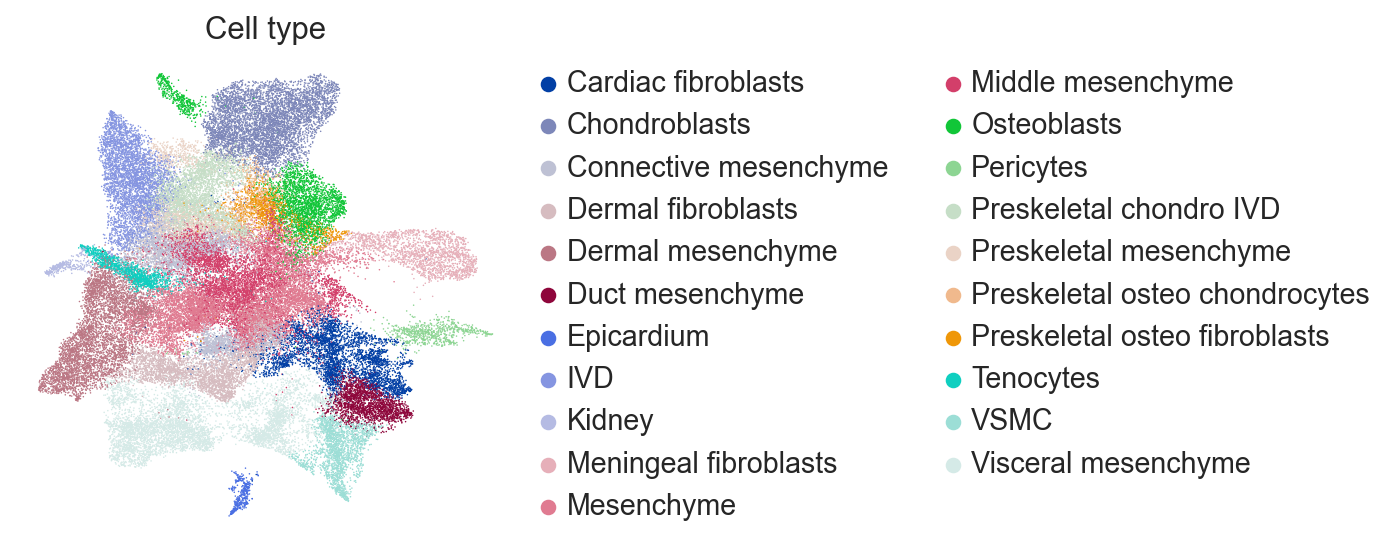

In [3]:
adata = sc.read_h5ad("adata_trunk_mes.h5ad")
clones = sc.read_h5ad("clones_trunk_mes.h5ad")

sc.pl.umap(adata, color="celltype_l1", frameon=False, title="Cell type")

We see here that boundaries between different cell types are quite fuzzy, and it's a perfect example of the case where cluster-free approach might make sense. Before training the actual model, let's dive deeper into some of the arguments of `sl.tl.predict_c2v` function:
1. **`ct_col`** — column in `adata.obs` with cell type labels. This information is used in three separate procedures:<br>(1) If more than one cell from the clone belongs to the same cell type, their expression might be aggregated into one (pseudobulked). If there is a hige inbalance in clone sizes, it might help to identify gene expression predictors across clones rather than across cells.<br>(2) The categorical feature with cell type identity might be used during training of the model to exclude the influence of cell type identity itself on the result (in the extreme situation where we strongly have only two types of clones — only in cell type A and only in cell type B — it will be the strongest predictor).<br>(3) We can use only some specific cell type during training (e. g. progenitor cells) to identify predictors of early commitment.
2. **`pseudobulk`** — if the expression of the cells from the same clone in the same cell type should be aggregated before training the model (scenario (1) from the examples above).
3. **`limit_ct`** — if the training should be limited by cells only from some specific cell type (scenarion (3) from the examples above).
4. **`use_ct`** — if the cell type identity of cells / clones should be used in the model (scenarion (2) from the examples above).

But we can anyway run a model without any prior cell type information.

In [8]:
shapdata_c2v = sl.tl.predict_c2v(
    adata,
    clones,
    clone_col="clone",
    use_gpu=True,
    verbose=False,
    use_ct=False,
    pseudobulk=False,
)

In [14]:
shapdata_c2v.var["average_shap"] = shapdata_c2v.layers["shap"].mean(axis=0).A[0]
shapdata_c2v.var.sort_values("average_shap", ascending=False).head(10)

,average_shap
Hoxc12,0.283680
Xist,0.256891
Hoxc13,0.231932
Postn,0.182164
Itm2a,0.179397
Zic1,0.173893
Hoxa11os,0.158277
Hoxa10,0.157785
Zfhx3,0.157531
Isl1,0.154701


/tmp/ipykernel_4083002/3636767898.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bar_colors = plt.cm.get_cmap("Reds")(norm(top_genes))[::-1]
/tmp/ipykernel_4083002/3636767898.py:9: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


Text(0.5, 1.0, 'Cluster-free clone2vec model')

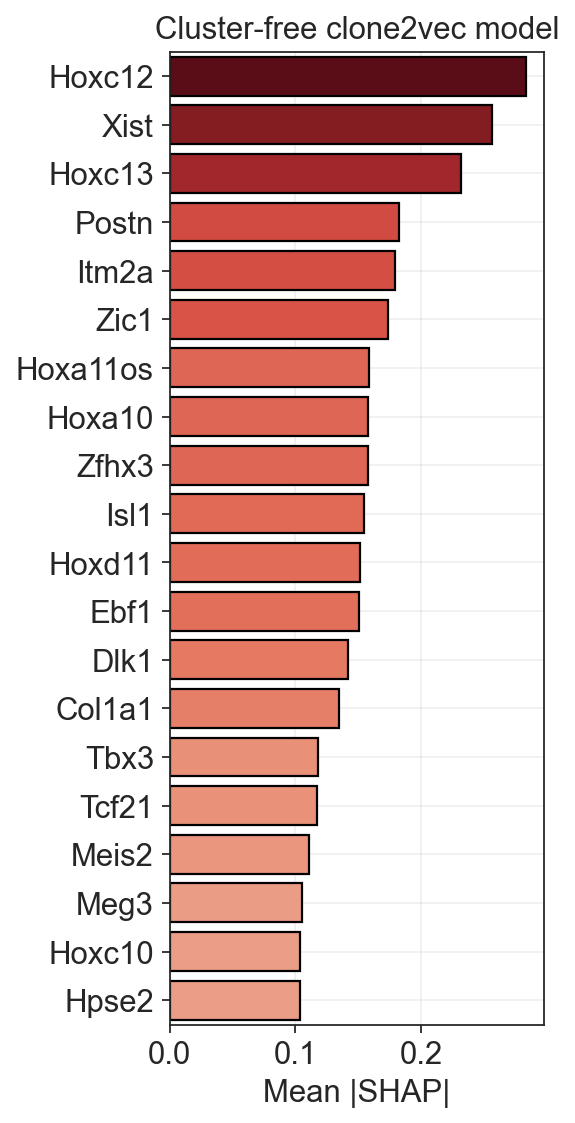

In [56]:
fig, ax = plt.subplots(figsize=(3, 8))

top_genes = shapdata_c2v.var.sort_values("average_shap", ascending=False).head(20).average_shap

norm = plt.Normalize(0, top_genes.max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
bar_colors = plt.cm.get_cmap("Reds")(norm(top_genes))[::-1]

sns.barplot(
    x=top_genes,
    y=top_genes.index,
    ax=ax,
    hue=top_genes.values,
    edgecolor="k",
    palette=bar_colors,
)

ax.grid(alpha=0.3)
ax.set_xlabel("Mean |SHAP|")
ax.set_ylabel("")
ax.legend_.remove()
ax.set_title("Cluster-free clone2vec model")

We see that the strongest predictors of clonal behaviour in our case are Hox genes and some important transcription factors. Also we see gene *Xist* as one of the predictors, and it's explained by inbalanced gender composition of mice in the dataset.

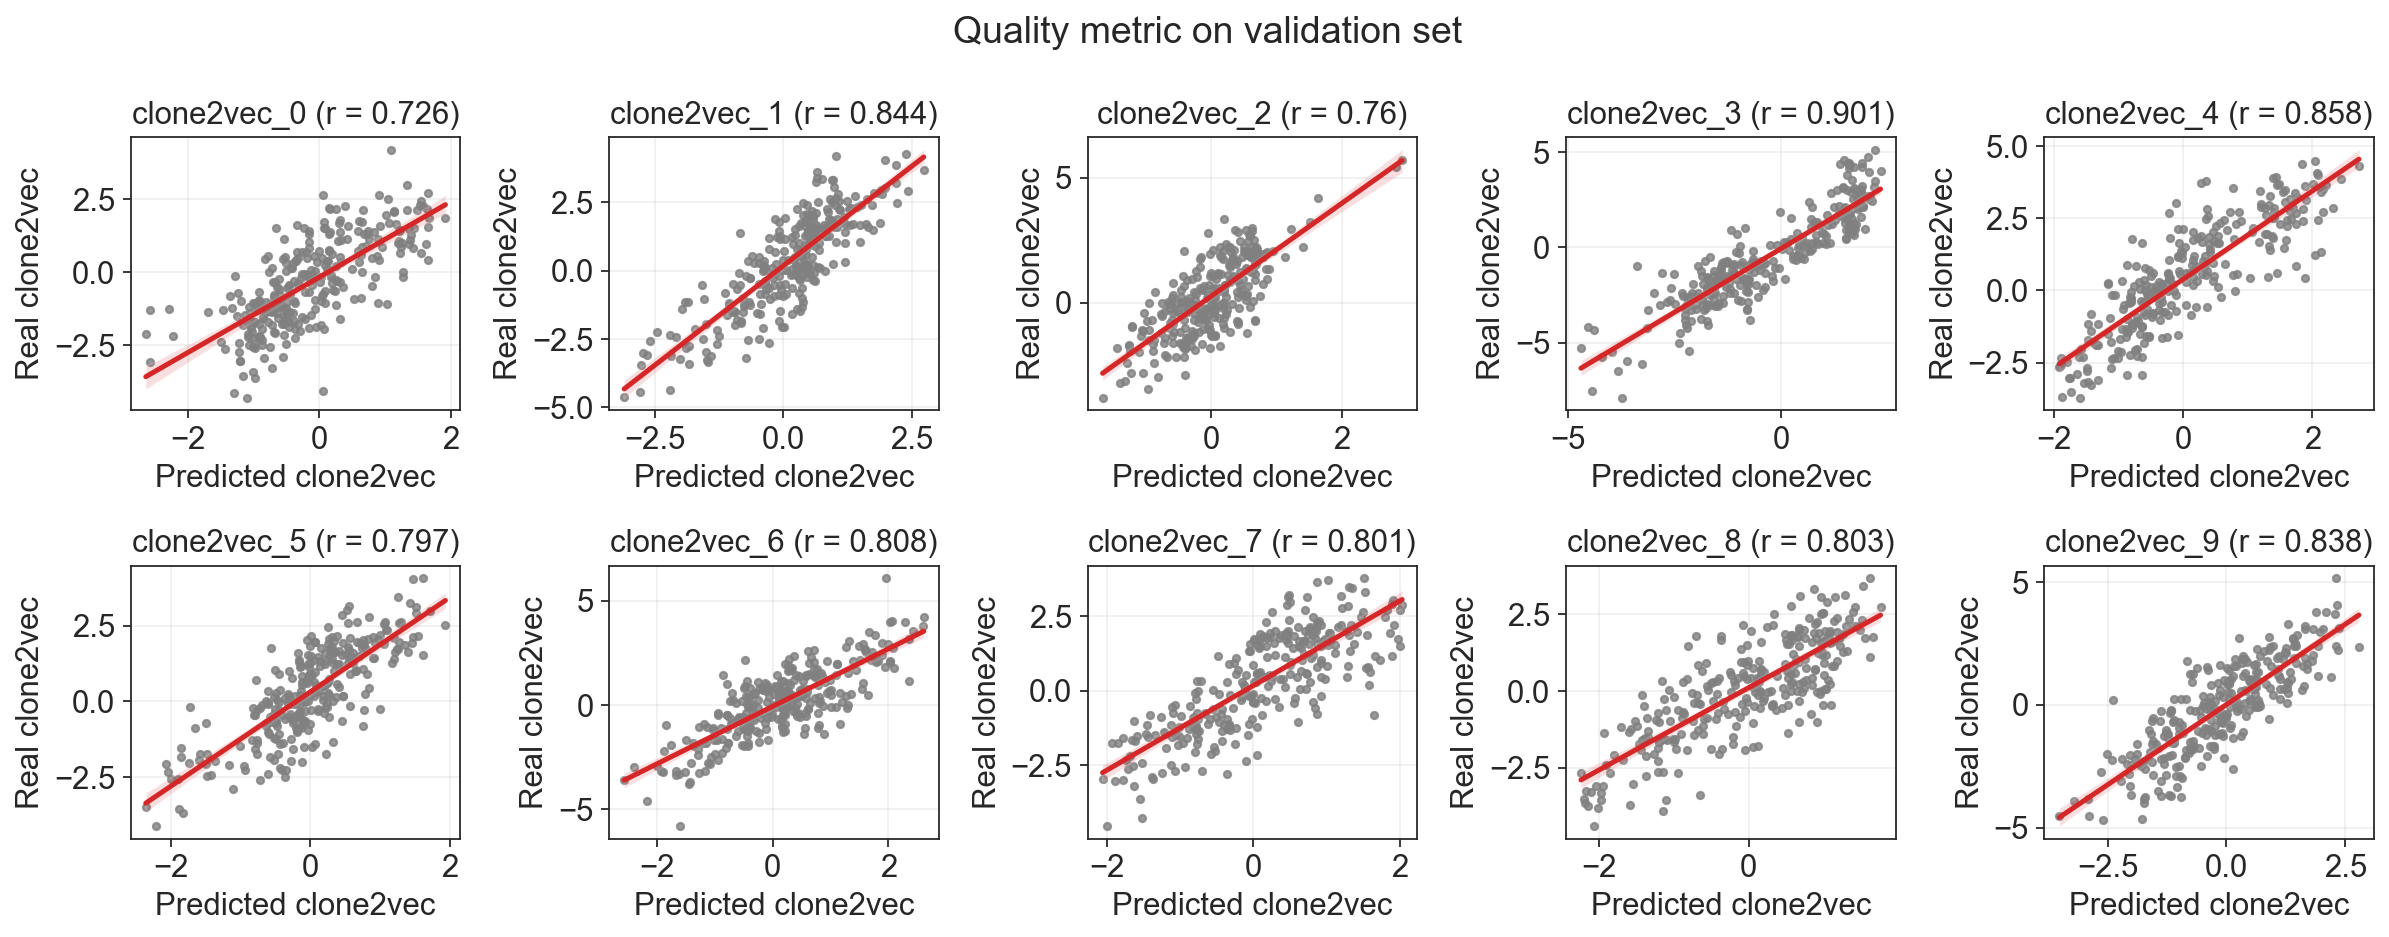

In [85]:
from scipy.stats import pearsonr

clones_validation = clones[clones.obs.eval_set == "validation"].copy()

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))

col = 0
row = 0

for i in range(10):
    ax = axes[row, col]
    
    sns.regplot(
        x=clones_validation.obsm["clone2vec_predicted"][:, i],
        y=clones_validation.obsm["clone2vec"][:, i],
        scatter_kws={"s": 10, "color": "grey"},
        line_kws={"color": sns.color_palette()[3]},
        ax = ax,
    )

    ax.grid(alpha=0.3)
    ax.set_xlabel("Predicted clone2vec")
    ax.set_ylabel("Real clone2vec")

    r = np.round(pearsonr(
        clones_validation.obsm["clone2vec_predicted"][:, i],
        clones_validation.obsm["clone2vec"][:, i],
    ).statistic, 3)
    ax.set_title(f"clone2vec_{i} (r = {r})")
    
    col += 1
    if col == 5:
        col = 0
        row = 1
        
plt.suptitle("Quality metric on validation set")
plt.tight_layout()

And now we have a question — how to interpret the result? We can directly analyse the distribution of selected marker genes on a clonal embedding.

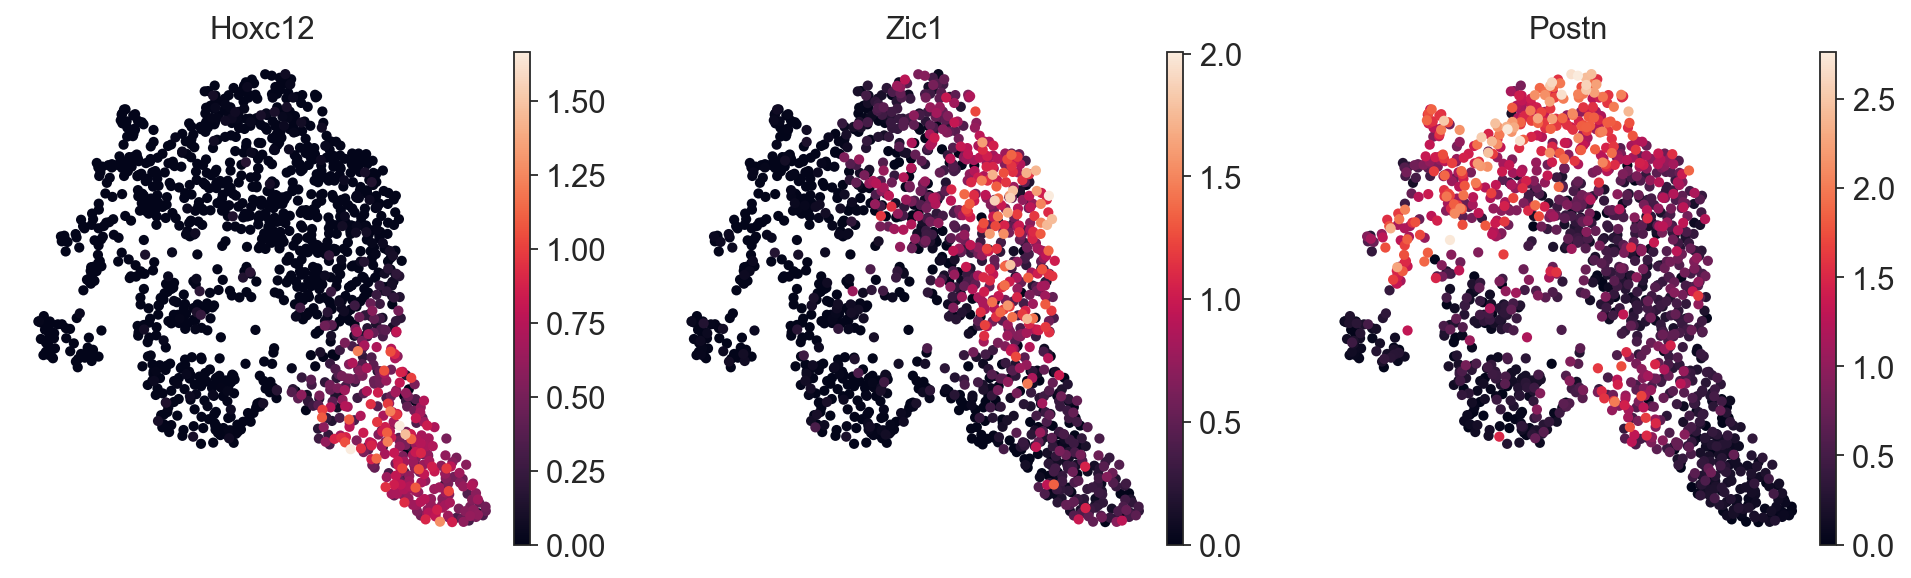

In [11]:
clones_expr = sl.tl.summarize_expression(adata, clones)
sc.pl.umap(clones_expr, color=["Hoxc12", "Zic1", "Postn"], frameon=False)

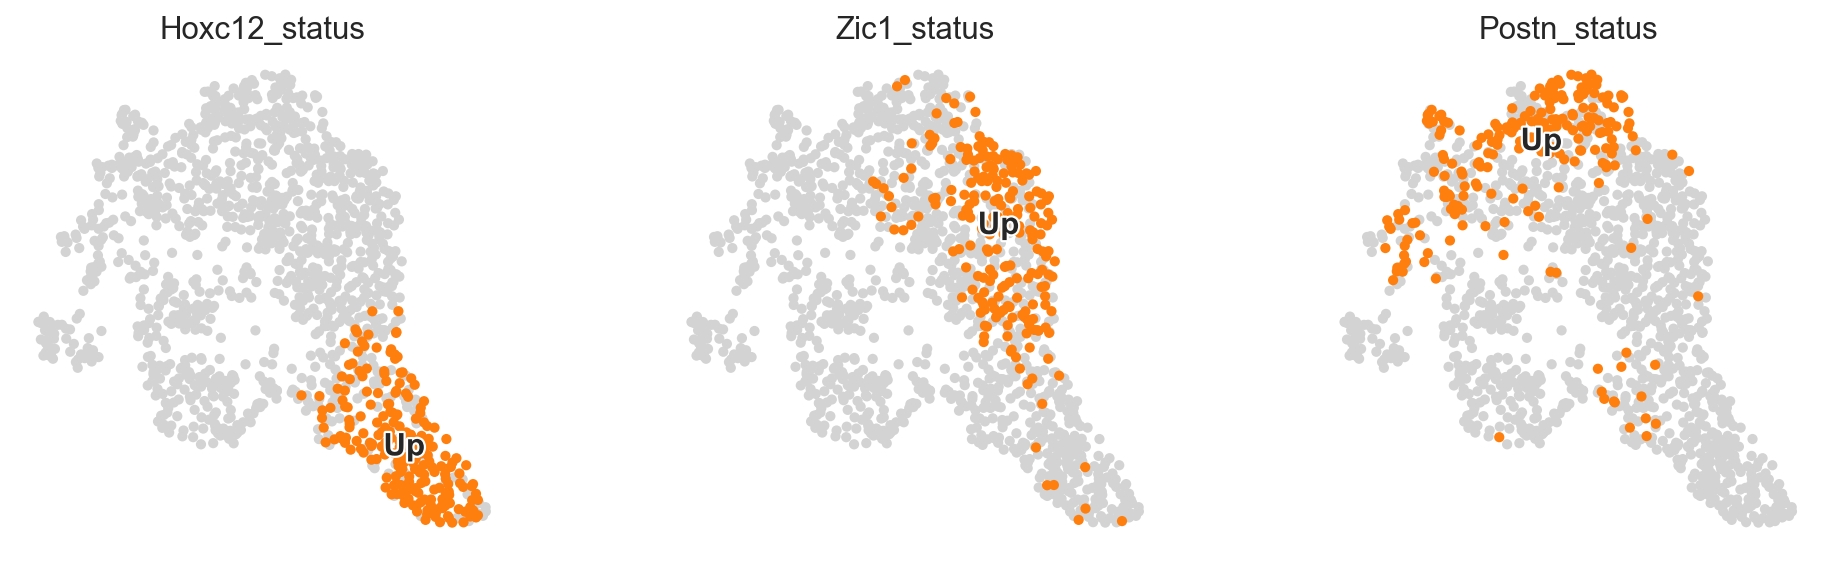

In [36]:
top_clones = 0.15
top_clones = int(len(clones) * top_clones)

for gene in ["Hoxc12", "Zic1", "Postn"]:
    selected_cells = np.argsort(clones_expr[:, gene].X.A.T[0])[-top_clones:]
    labels = np.array(["Down"] * len(clones))
    labels[selected_cells] = "Up"
    
    clones_expr.obs[f"{gene}_status"] = labels
    
sc.pl.umap(clones_expr, color=["Hoxc12_status", "Zic1_status", "Postn_status"], frameon=False,
           legend_loc="on data", legend_fontoutline=2, groups=["Up"], na_in_legend=False)

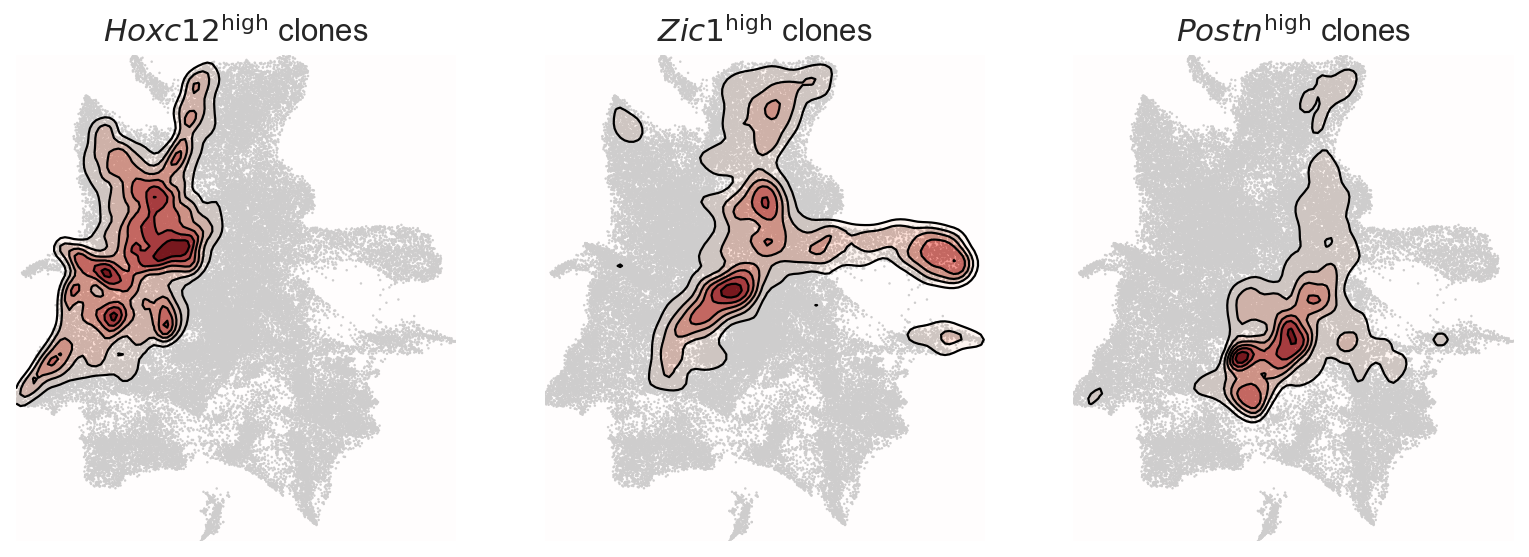

In [49]:
for gene in ["Hoxc12", "Zic1", "Postn"]:
    sl.tl.transfer_clonal_annotation(
        adata,
        clones_expr,
        adata_clone_name="clone",
        adata_obs_name=f"{gene}_status",
        clones_obs_name=f"{gene}_status",
    )
    
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sl.pl.kde(adata, groupby="Hoxc12_status", group="Up", title="$Hoxc12^{\mathrm{high}}$ clones", ax=axes[0])
sl.pl.kde(adata, groupby="Zic1_status", group="Up", title="$Zic1^{\mathrm{high}}$ clones", ax=axes[1])
sl.pl.kde(adata, groupby="Postn_status", group="Up", title="$Postn^{\mathrm{high}}$ clones", ax=axes[2])